In this notebook are presented some computations performed in Python in a complementary way to everything done in MATLAB, particularly Table 1, 2 and Figures 3 and 4. 

# 1. Libraries and reading   


In [1]:
#!pip install fuzzywuzzy
#!pip install python-Levenshtein
#!pip install h5py
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import scipy.io
from datetime import datetime
import warnings
import h5py
from scipy.stats import kruskal
from scipy.stats import ttest_1samp
import statsmodels.api as sm
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

In [2]:
# Load Files 
subjects_mat = scipy.io.loadmat('Data raw\subjects.mat', variable_names=['fsdata', 'nuisance','subjects'])
subjects = subjects_mat["subjects"]
fsdata= pd.DataFrame(subjects_mat["fsdata"])
nuisance = pd.DataFrame(subjects_mat["nuisance"])
PET = pd.read_csv('Data raw\parcellated_petfiles.csv')
all = pd.read_csv('Data raw\DoentesDOENTESbvFTDDAMCIFINALUNIFORMIZADOFINALCopyS3.csv')
taus = pd.read_csv('Data raw\\taus.csv')
volum = pd.read_csv('Data raw\\volumen.csv') # All the volumetrics from : Doentes_DOENTES_bvFTD_DA_MCI_FINAL_UNIFORMIZADO_FINA
short_names = ['5HT1a','5HT1b','5HT2a','D1','D2','DAT','FDOPA','GABAa','Mu opioid','NAT','SERT','VAChT','mGluR5']

# 2. Data pre-processing

In [3]:
# Column and index adjustment 
PET.set_index('File', inplace=True)
fsdata.columns = PET.columns  # The Pet data and fsdata (subjects) variables are the same(83).  
nuisance.columns = ["Female","Age","TIV"]

# Transformation of Matlab format to be recognized by python 
subjects_list = [[subjects[i][j] for j in range(subjects.shape[1])] for i in range(subjects.shape[0])]
subjects_df = pd.DataFrame(subjects_list) # 

# Subjects information 
columns_sub = volum[['Subject', 'Group']]

Creation of the final dataset with all information 

In [4]:
# Selection of variables of each set 
taus_and_exams = all[['ApoE', 'Ab42', 'Tau', 'pTau', 'Ab4240','MMSE', 'ADASCog','MoCA']] 
volumetrics = volum[['BrainSegVol','CortexVol','CerebralWhiteMatterVol','lhCerebralWhiteMatterVol','rhCerebralWhiteMatterVol','SubCortGrayVol','TotalGrayVol']]

# Join 
final = pd.concat([columns_sub,nuisance, taus_and_exams, volumetrics,fsdata], axis=1)

final['Subject'] = final['Subject'].str.replace('sub-', '') # Cleaning 
final.head()

,Subject,Group,Female,Age,TIV,ApoE,Ab42,Tau,pTau,Ab4240,...,r_transversetemporal,r_insula,r_thalamusproper,r_caudate,r_putamen,r_pallidum,r_accumbensarea,r_hippocampus,r_amygdala,brainstem
0,102,bvFTD,1.0,74.0,1523927.365,"e3,e4",NaN,NaN,NaN,NaN,...,0.624,6.230,5.579700,3.4582,4.1495,1.6170,0.3904,3.1943,1.1173,19.3922
1,104,bvFTD,0.0,81.0,1278850.725,<undefined>,1827.4,398.9,60.8,NaN,...,0.638,5.405,5.924933,2.5811,4.6616,1.3286,0.2428,3.0288,1.0963,15.7909
2,105,bvFTD,0.0,65.0,1612421.105,<undefined>,708.1,367.6,70.0,0.051543,...,0.720,7.454,6.384100,3.1743,4.0040,1.8389,0.5101,4.4443,1.6947,23.8432
3,106,bvFTD,0.0,66.0,1424354.184,"e3,e3",1091.5,394.5,42.8,NaN,...,0.717,5.498,6.318900,3.1707,4.1841,1.7213,0.4747,3.8634,1.3225,18.6049
4,107,bvFTD,0.0,71.0,1982835.850,"e2,e3",528.7,84.9,19.6,NaN,...,0.984,8.603,7.779100,3.7992,4.8489,2.1917,0.5011,4.5070,1.8961,18.4077


# 3. General summary tables  

In [5]:
# Selection of variables according to the tests to be performed

kruskal_vars = ['Group', 'Age', 'TIV', 'Ab42', 'Tau', 'pTau', 'Ab4240', 'MMSE', 'ADASCog', 'MoCA', 'BrainSegVol', 'CortexVol', 'CerebralWhiteMatterVol', 'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'SubCortGrayVol', 'TotalGrayVol']
chi2_vars = ['Group','Female', 'ApoE']  

final_kruskal = final[kruskal_vars]
final_chi = final[chi2_vars]


## 3.1 Kruskal Wallis 

In [6]:

# Create a list to store the results
all_results = []

# Iterate over all variables in final_kruskal (except 'Group')
for var in final_kruskal.columns[1:]:
    # Filter the current variable and handle missing values
    data_var = final_kruskal[['Group', var]].dropna()
    
    # Ensure the groups are in the correct order
    group_labels = ['AD', 'bvFTD', 'MCI']
    data_by_group = [data_var.loc[data_var['Group'] == group, var] for group in group_labels]
    
    # Perform the Kruskal-Wallis test
    stat, p_value = kruskal(*data_by_group)
    
    # Calculate n, mean, and sd for each group
    ns = [group_data.count() for group_data in data_by_group]
    means = [group_data.mean() for group_data in data_by_group]
    sds = [group_data.std() for group_data in data_by_group]
    
    # Calculate the effect size
    effect_size = (max(means) - min(means)) / np.mean(sds)
    
    # Store the results in the list
    all_results.append([
        var,
        ns[0], means[0], sds[0],
        ns[1], means[1], sds[1],
        ns[2], means[2], sds[2],
        p_value, effect_size
    ])

# Create a DataFrame with all the results
results_df = pd.DataFrame(all_results, columns=[
    'Variable', 
    'n_AD', 'mean_AD', 'sd_AD',
    'n_bvFTD', 'mean_bvFTD', 'sd_bvFTD',
    'n_MCI', 'mean_MCI', 'sd_MCI',
    'p_value', 'effect_size'
])


Adjustment of P values by FDR and Bonferroni 

In [7]:
#'results_df' already contains the original p-values
p_values = results_df['p_value'].values

# Bonferroni correction
bonferroni_corrected_pvals = multipletests(p_values, method='bonferroni')[1]

# FDR (False Discovery Rate) correction
fdr_corrected_pvals = multipletests(p_values, method='fdr_bh')[1]

# Add the results to the DataFrame
results_df['bonferroni_corrected_p_value'] = bonferroni_corrected_pvals
results_df['fdr_corrected_p_value'] = fdr_corrected_pvals


For export facility at a later stage (optional)

In [8]:
def format_p_value(p):
    if p < 0.01:
        return "<0.01**"
    elif 0.01 <= p <= 0.05:
        return f"{p:.2f}*"
    else:
        return f"{p:.2f}"

# Create additional columns with formatted p-value
results_df['formatted_p_value'] = results_df['p_value'].apply(format_p_value)
results_df['formatted_bonferroni_p_value'] = results_df['bonferroni_corrected_p_value'].apply(format_p_value)
results_df['formatted_fdr_p_value'] = results_df['fdr_corrected_p_value'].apply(format_p_value)

results_df.head()

#file_path = "set route"
#results_df.to_excel(file_path, index=False)


,Variable,n_AD,mean_AD,sd_AD,n_bvFTD,mean_bvFTD,sd_bvFTD,n_MCI,mean_MCI,sd_MCI,p_value,effect_size,bonferroni_corrected_p_value,fdr_corrected_p_value,formatted_p_value,formatted_bonferroni_p_value,formatted_fdr_p_value
0,Age,88,7.001136e+01,8.291381,75,6.501333e+01,9.322297,51,7.292157e+01,7.396873,9.964552e-06,0.948588,1.594328e-04,2.657214e-05,<0.01**,<0.01**,<0.01**
1,TIV,88,1.442205e+06,151336.956448,75,1.465511e+06,241395.934903,51,1.399764e+06,127734.843687,1.636681e-01,0.378974,1.000000e+00,2.587381e-01,0.16,1.00,0.26
2,Ab42,45,4.515753e+02,181.599905,63,7.910270e+02,279.058278,28,6.022943e+02,336.502586,1.464214e-09,1.277478,2.342743e-08,1.171372e-08,<0.01**,<0.01**,<0.01**
3,Tau,45,5.849581e+02,368.662416,64,2.896545e+02,164.953785,28,3.967929e+02,258.869969,7.963023e-07,1.117888,1.274084e-05,3.185209e-06,<0.01**,<0.01**,<0.01**
4,pTau,45,6.825598e+01,31.841698,64,3.574354e+01,15.244582,28,5.509429e+01,27.941050,2.734251e-09,1.300024,4.374801e-08,1.458267e-08,<0.01**,<0.01**,<0.01**


## 3.2 Chi-squared

In [9]:

# Create a list to store the results
all_chi2_results = []

# Iterate over all categorical variables in final_chi (except 'Group')
for var in final_chi.columns[1:]:
    # Filter the data to remove missing values
    data_var = final_chi[['Group', var]].dropna()
    
    # Create a contingency table
    contingency_table = pd.crosstab(data_var['Group'], data_var[var])
    
    # Perform the Chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate the effect size (Cramer's V)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    effect_size = np.sqrt(chi2 / (n * min_dim))
    
    # Store the results in the list
    all_chi2_results.append([
        var,
        p_value,
        effect_size
    ])

# Create a DataFrame with all the results
chi2_results_df = pd.DataFrame(all_chi2_results, columns=[
    'Variable', 
    'p_value', 
    'Effect Size (Cramer\'s V)'
])

# Adjust p-values using FDR (False Discovery Rate)
chi2_results_df['fdr_corrected_p_value'] = multipletests(chi2_results_df['p_value'], method='fdr_bh')[1]

chi2_results_df.head()

#file_path = "set route"
#chi2_results_df.to_excel(file_path, index=False)

,Variable,p_value,Effect Size (Cramer's V),fdr_corrected_p_value
0,Female,0.039700,0.173647,0.039700
1,ApoE,0.000153,0.298037,0.000305


 # 4. Correlation Analysis     

## 4.1 Neurotransmitter/brain region significance 

In [10]:
# Define the indices of the rows of interest
pet_of_interest_indices = [0, 3, 5, 9, 10, 12, 13, 14, 17, 19, 23, 24, 29]

# Select the rows of interest
petdata = PET.iloc[pet_of_interest_indices, :]
petdata.index = short_names

fsdata.index = final.Subject;final.index = final.Subject
nuisance.index = final.Subject



Elimination of noise variables (in each subject) by means of regression 

In [11]:

# Add a column of ones for the intercept in the regression
nuisance = sm.add_constant(nuisance)

# Create a DataFrame to store the residuals
fsdata_residuals = pd.DataFrame()

# Perform regression and store residuals
for col in fsdata.columns:
    model = sm.OLS(fsdata[col], nuisance).fit()
    fsdata_residuals[col] = model.resid

fsdata_residuals = pd.concat([final['Group'],fsdata_residuals],axis=1 )
# Now `fsdata_residuals` contains the GMV variables residuals after removing the effect of nuisance variables
fsdata_residuals.head()



,Group,l_bankssts,l_caudalanteriorcingulate,l_caudalmiddlefrontal,l_cuneus,l_entorhinal,l_fusiform,l_inferiorparietal,l_inferiortemporal,l_isthmuscingulate,...,r_transversetemporal,r_insula,r_thalamusproper,r_caudate,r_putamen,r_pallidum,r_accumbensarea,r_hippocampus,r_amygdala,brainstem
Subject,,,,,,,,,,,,,,,,,,,,,
102,bvFTD,-0.104359,0.216095,0.102317,0.008984,0.206099,2.063650,1.148147,1.507387,0.185265,...,-0.063258,0.389929,-0.154165,0.202828,0.020078,-0.149911,-0.002544,0.075986,-0.166021,1.056332
104,bvFTD,-0.338026,-0.163401,-0.624999,0.603882,0.132626,-1.713712,-0.793767,-2.221988,-0.128441,...,-0.103306,-0.443541,0.274727,-0.622806,0.515306,-0.391639,-0.152987,-0.163124,-0.275518,-3.895690
105,bvFTD,1.465045,0.217766,-0.178685,0.038220,1.068174,1.697083,2.104722,2.914809,0.621737,...,-0.065217,0.984368,-0.003403,-0.153303,-0.350382,-0.046613,0.078601,0.916198,0.208261,3.396881
106,bvFTD,-0.068403,-0.304058,1.212721,0.119100,-0.938181,-1.739485,0.092881,-3.132726,0.465905,...,-0.058002,-0.593600,0.135195,-0.004431,0.017294,-0.102917,0.058051,0.401823,-0.118772,-1.577599
107,bvFTD,0.720529,-0.844833,-0.280975,-0.468414,0.314114,4.518902,3.139038,1.638899,0.251732,...,0.193114,1.361116,1.200734,0.089086,0.055265,0.217139,0.045605,0.970100,0.340035,-2.394771


Correlation Matrix and Z-transformed correlation 

In [12]:
# Temporarily remove the 'Group' column from fsdata_residuals for correlation calculations
fsdata_residuals_no_group = fsdata_residuals.drop(columns=['Group'])

# Create an empty matrix to store correlations
correlation_matrix = pd.DataFrame(index=fsdata_residuals_no_group.index, columns=petdata.index)

# Calculate correlations
for neurotransmitter in petdata.index:
    for individual in fsdata_residuals_no_group.index:
        # Correlation between GMV variables for an individual and the neurotransmitter
        rho, pval = spearmanr(fsdata_residuals_no_group.loc[individual, :].values, petdata.loc[neurotransmitter, :].values)
        correlation_matrix.loc[individual, neurotransmitter] = rho

# Add back the 'Group' column to the correlation matrix
correlation_matrix['Group'] = fsdata_residuals['Group']

# Apply Fisher's atanh transformation to each element of the correlation matrix using map
transformed_corr_matrix = correlation_matrix.drop(columns=['Group']).apply(lambda x: x.map(np.arctanh))

# Add back the 'Group' column to identify which group each individual belongs to
transformed_corr_matrix['Group'] = correlation_matrix['Group']
transformed_corr_matrix.head()


,5HT1a,5HT1b,5HT2a,D1,D2,DAT,FDOPA,GABAa,Mu opioid,NAT,SERT,VAChT,mGluR5,Group
Subject,,,,,,,,,,,,,,
102,0.138574,-0.381618,-0.028869,0.013224,-0.024794,0.044654,0.184076,0.186638,-0.184966,0.009761,-0.021203,-0.226829,0.015513,bvFTD
104,-0.094313,0.165143,0.020132,0.167495,0.188421,0.189465,0.145727,-0.008102,-0.049324,-0.017150,0.298356,0.049934,-0.019166,bvFTD
105,0.399815,-0.095160,0.216207,-0.005122,-0.304347,0.000420,-0.012448,0.286640,-0.006549,-0.101094,-0.084813,-0.183533,0.047767,bvFTD
106,-0.372357,0.046442,-0.103088,-0.148537,0.289397,-0.314403,-0.340572,0.125183,-0.270460,0.011461,-0.413673,-0.073534,0.203052,bvFTD
107,0.136756,-0.248406,0.084306,-0.461003,-0.173739,-0.474615,-0.324078,0.037800,-0.110604,0.061936,-0.460797,-0.319106,-0.109223,bvFTD


In [13]:
# Mean of transformed correlations for the total sample
total_means = transformed_corr_matrix.drop(columns=['Group']).mean()

# Mean of transformed correlations by group
group_means = transformed_corr_matrix.groupby('Group').mean()

In [16]:
# Create an empty DataFrame to store results
results_table = pd.DataFrame()

# Iterate over each neurotransmitter to calculate values by group
for neurotransmitter in transformed_corr_matrix.columns[:-1]:  # Excludes 'Group' column
    # Filter by group
    ad_data = transformed_corr_matrix[transformed_corr_matrix['Group'] == 'AD'][neurotransmitter]
    bvftd_data = transformed_corr_matrix[transformed_corr_matrix['Group'] == 'bvFTD'][neurotransmitter]
    mci_data = transformed_corr_matrix[transformed_corr_matrix['Group'] == 'MCI'][neurotransmitter]
    
    # Calculate means
    mean_ad = ad_data.mean()
    mean_bvftd = bvftd_data.mean()
    mean_mci = mci_data.mean()
    
    # Perform t-tests
    t_ad, p_ad = ttest_1samp(ad_data, 0)
    t_bvftd, p_bvftd = ttest_1samp(bvftd_data, 0)
    t_mci, p_mci = ttest_1samp(mci_data, 0)
    
    # Create a temporary DataFrame for this neurotransmitter
    temp_df = pd.DataFrame({
        'Neurotransmitter': [neurotransmitter],
        'Mean_AD': [mean_ad], 'T_AD': [t_ad], 'P_AD': [p_ad],
        'Mean_bvFTD': [mean_bvftd], 'T_bvFTD': [t_bvftd], 'P_bvFTD': [p_bvftd],
        'Mean_MCI': [mean_mci], 'T_MCI': [t_mci], 'P_MCI': [p_mci]
    })
    
    # Concatenate to the results DataFrame
    results_table = pd.concat([results_table, temp_df], ignore_index=True)

results_table.head()

#file_path = "set route"
#formatted_results_table.to_excel(file_path, index=False)


,Neurotransmitter,Mean_AD,T_AD,P_AD,Mean_bvFTD,T_bvFTD,P_bvFTD,Mean_MCI,T_MCI,P_MCI
0,5HT1a,0.012625,0.602117,0.548663,0.004440,0.141652,0.887740,0.026971,0.876389,0.385010
1,5HT1b,0.037671,2.134196,0.035640,-0.022478,-1.332568,0.186762,-0.037179,-1.643209,0.106615
2,5HT2a,0.013508,0.692326,0.490576,-0.014943,-0.808356,0.421477,0.021818,1.013145,0.315869
3,D1,0.024211,1.006444,0.316993,0.014228,0.478135,0.633963,-0.047663,-1.608833,0.113950
4,D2,-0.035575,-2.107239,0.037975,0.033258,1.629523,0.107452,-0.004649,-0.210223,0.834348


## 4.2 Kruskal wallis summary and figures 3 and 4

In [17]:

# Function to calculate coefficient of variation
def coeff_of_variation(data):
    return np.std(data) / np.mean(data)

# Create a DataFrame to store final results
final_results = pd.DataFrame(columns=['Neurotransmitter', 'Mean_AD (CV)', 'Mean_bvFTD (CV)', 'Mean_MCI (CV)', 'P_value', 'Effect_Size'])

# Iterate over each neurotransmitter and perform calculations
for neurotransmitter in correlation_matrix.columns[:-1]:  # Exclude 'Group' column
    # Extract data for each group
    ad_data = correlation_matrix[correlation_matrix['Group'] == 'AD'][neurotransmitter]
    bvftd_data = correlation_matrix[correlation_matrix['Group'] == 'bvFTD'][neurotransmitter]
    mci_data = correlation_matrix[correlation_matrix['Group'] == 'MCI'][neurotransmitter]
    
    # Calculate means and coefficients of variation
    mean_ad = np.mean(ad_data)
    cv_ad = coeff_of_variation(ad_data)
    mean_bvftd = np.mean(bvftd_data)
    cv_bvftd = coeff_of_variation(bvftd_data)
    mean_mci = np.mean(mci_data)
    cv_mci = coeff_of_variation(mci_data)
    
    # Perform Kruskal-Wallis test
    H_stat, p_value = kruskal(ad_data, bvftd_data, mci_data)
    
    # Calculate effect size (Eta Squared)
    N = len(ad_data) + len(bvftd_data) + len(mci_data)
    eta_squared = (H_stat - 3 + 1) / (N - 3)
    
    # Create a row of results
    temp_df = pd.DataFrame({
        'Neurotransmitter': [neurotransmitter],
        'Mean_AD (CV)': [f"{mean_ad:.3f} ({cv_ad:.3f})"],
        'Mean_bvFTD (CV)': [f"{mean_bvftd:.3f} ({cv_bvftd:.3f})"],
        'Mean_MCI (CV)': [f"{mean_mci:.3f} ({cv_mci:.3f})"],
        'P_value': [p_value],
        'Effect_Size': [eta_squared]
    })
    
    # Concatenate results to final DataFrame
    final_results = pd.concat([final_results, temp_df], ignore_index=True)

# Round p_value and effect_size to 3 significant digits
final_results['P_value'] = final_results['P_value'].apply(lambda x: f"{x:.3f}")
final_results['Effect_Size'] = final_results['Effect_Size'].apply(lambda x: f"{x:.3f}")

# Display final results
final_results.head()

#file_path = "set route"
#final_results.to_excel(file_path, index=False)


C:\Users\lamun\AppData\Local\Temp\ipykernel_53264\911055934.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, temp_df], ignore_index=True)


,Neurotransmitter,Mean_AD (CV),Mean_bvFTD (CV),Mean_MCI (CV),P_value,Effect_Size
0,5HT1a,0.012 (16.159),0.005 (52.620),0.027 (7.711),0.747,-0.007
1,5HT1b,0.036 (4.420),-0.022 (-6.522),-0.036 (-4.295),0.024,0.026
2,5HT2a,0.013 (13.327),-0.015 (-10.416),0.021 (7.001),0.322,0.001
3,D1,0.022 (9.754),0.014 (17.503),-0.046 (-4.404),0.285,0.002
4,D2,-0.035 (-4.428),0.033 (5.254),-0.004 (-36.779),0.030,0.024


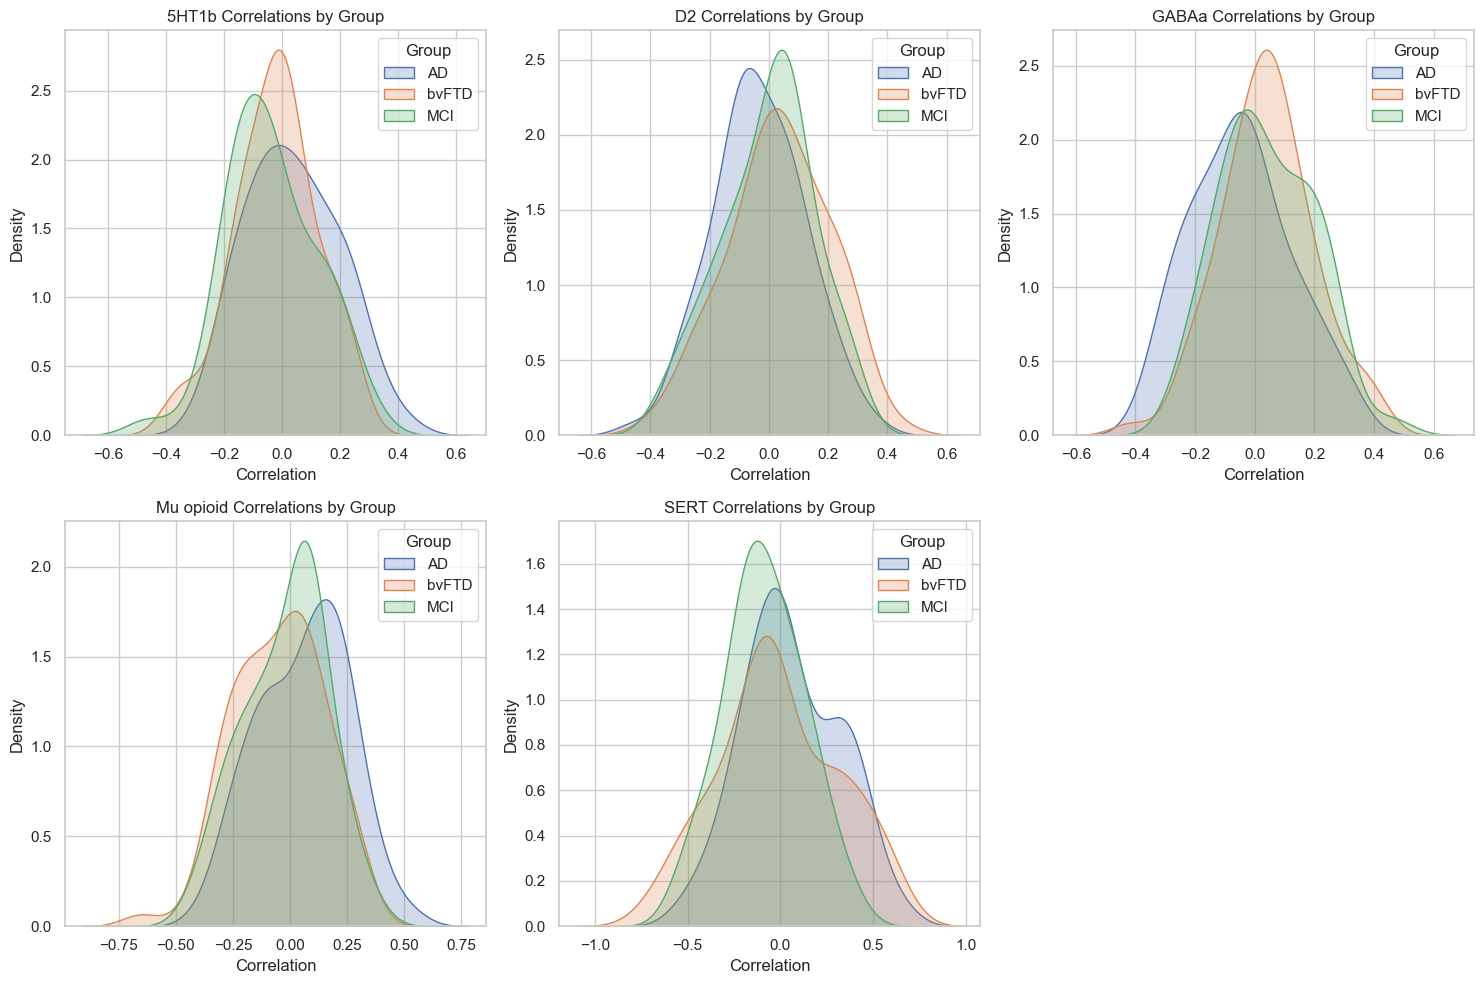

In [18]:
# Set up plot style
sns.set(style="whitegrid")

# Filter only significant neurotransmitters
significant_neurotransmitters = final_results[final_results['P_value'].astype(float) < 0.05]['Neurotransmitter']

# Create a figure and subplot matrix
num_plots = len(significant_neurotransmitters)
rows = (num_plots // 3) + int(num_plots % 3 > 0)  # Calculate needed rows
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))

# Iterate over each neurotransmitter and create corresponding plot
for i, neurotransmitter in enumerate(significant_neurotransmitters):
    row, col = divmod(i, 3)  # Calculate subplot position
    ax = axes[row, col]
    
    # Plot density for each group
    sns.kdeplot(data=correlation_matrix[correlation_matrix['Group'] == 'AD'][neurotransmitter], label='AD', fill=True, ax=ax)
    sns.kdeplot(data=correlation_matrix[correlation_matrix['Group'] == 'bvFTD'][neurotransmitter], label='bvFTD', fill=True, ax=ax)
    sns.kdeplot(data=correlation_matrix[correlation_matrix['Group'] == 'MCI'][neurotransmitter], label='MCI', fill=True, ax=ax)
    
    # Add title and labels
    ax.set_title(f'{neurotransmitter} Correlations by Group')
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Density')
    ax.legend(title='Group')
    
# Remove empty axes if number of plots isn't multiple of 3
for j in range(i+1, rows * 3):
    fig.delaxes(axes.flatten()[j])

# Adjust layout
plt.tight_layout()
plt.show()


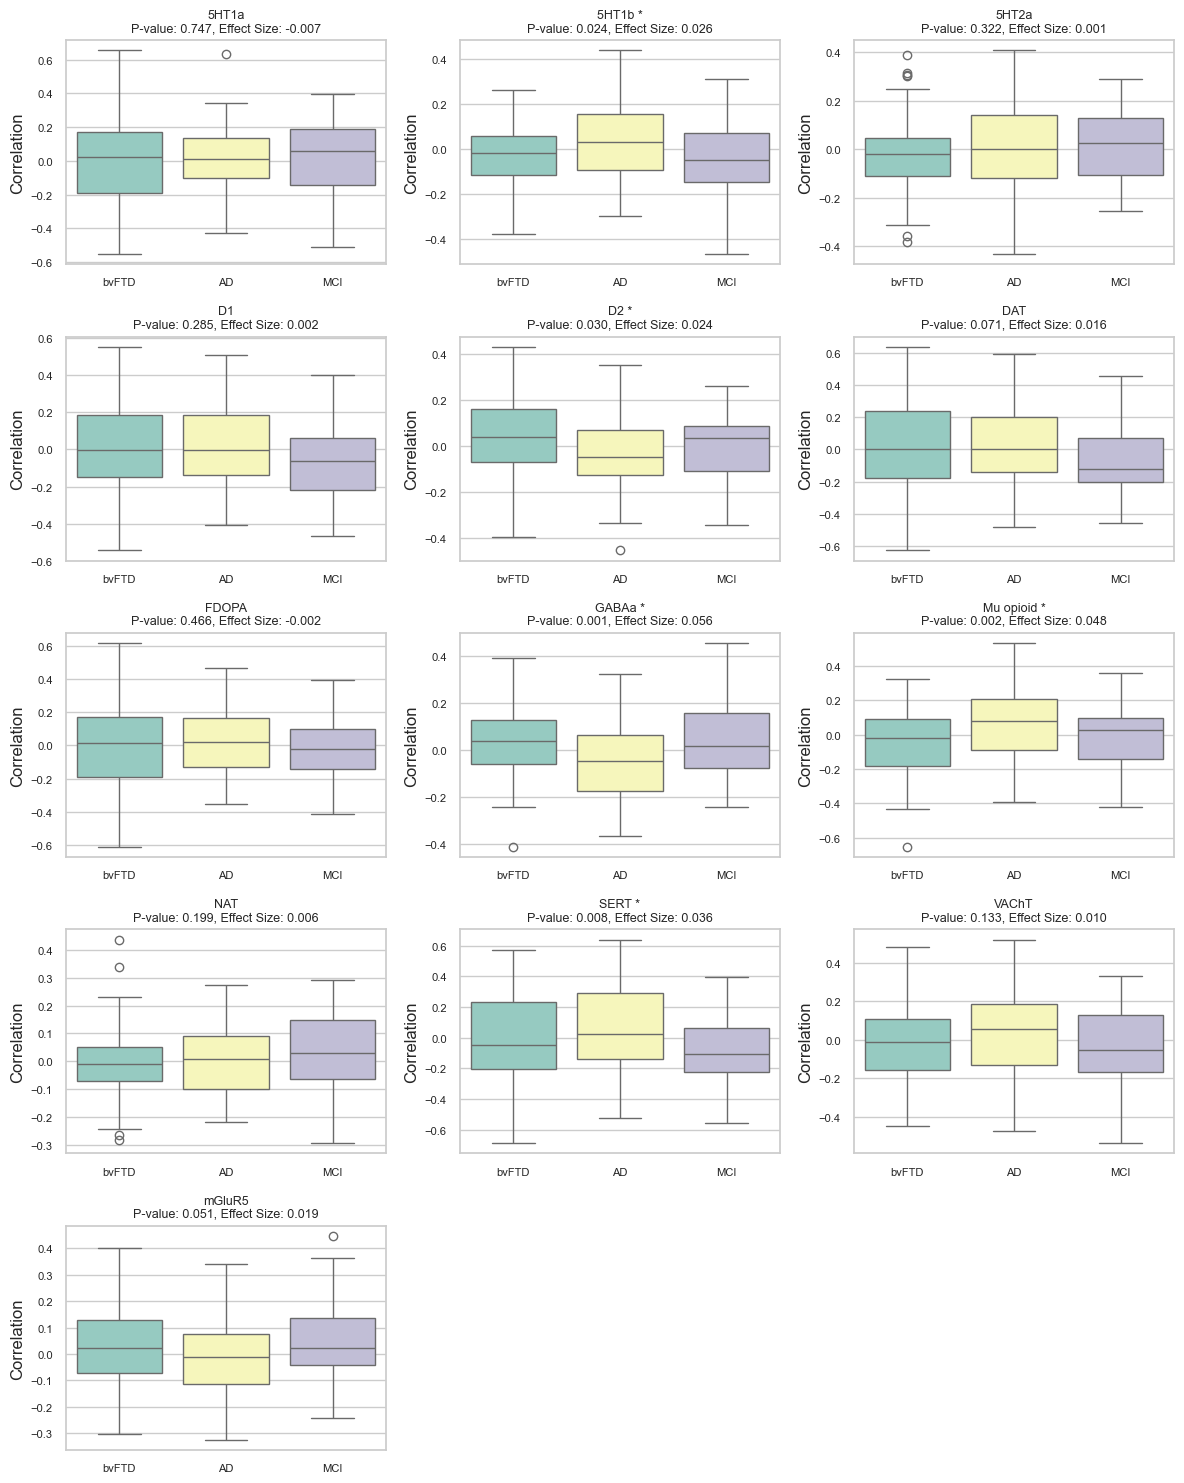

In [ ]:
# Set up plot style
sns.set(style="whitegrid")

# Get significant neurotransmitters
significant_neurotransmitters = final_results[final_results['P_value'].astype(float) < 0.05]['Neurotransmitter']

# Create figure and subplot matrix
num_plots = len(correlation_matrix.columns[:-1])  # Exclude 'Group' column
rows = (num_plots // 3) + int(num_plots % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(12, rows * 3))

# Iterate over each neurotransmitter and create corresponding plot
for i, neurotransmitter in enumerate(correlation_matrix.columns[:-1]):  # Exclude 'Group' column
    row, col = divmod(i, 3)
    ax = axes[row, col]
    
    # Create boxplot
    sns.boxplot(x='Group', y=neurotransmitter, data=correlation_matrix, ax=ax, hue='Group', palette="Set3", dodge=False)
    
    # Get p-value and effect size values
    p_value = final_results[final_results['Neurotransmitter'] == neurotransmitter]['P_value'].values[0]
    effect_size = final_results[final_results['Neurotransmitter'] == neurotransmitter]['Effect_Size'].values[0]
    
    # Mark significant neurotransmitters
    title = neurotransmitter
    if neurotransmitter in significant_neurotransmitters.values:
        title += " *"
    
    # Add title and labels
    ax.set_title(f'{title}\nP-value: {p_value}, Effect Size: {effect_size}', fontsize=9)
    ax.set_xlabel('')
    ax.set_ylabel('Correlation')
    ax.tick_params(axis='both', which='major', labelsize=8)

# Hide empty plots in the last row if necessary
total_plots = len(correlation_matrix.columns[:-1])
for j in range(total_plots, rows * 3):
    row, col = divmod(j, 3)
    axes[row, col].axis('off')  # Turn off axis for empty subplot

# Adjust layout to avoid overlap
plt.tight_layout()


# Display plot on screen
plt.show()

#output_file = "Path"
#fig.savefig(output_file, dpi=300, bbox_inches='tight', format='png')  


